In [1]:
from dask.distributed import Client
import os
from intake import open_esm_datastore, cat
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

from ruamel.yaml import YAML
ryaml = YAML()
ryaml.preserve_quotes = True

In [2]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44845 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44845/status,
Dashboard: /proxy/44845/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38347,Workers: 7
Dashboard: /proxy/44845/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36699,Total threads: 1
Dashboard: /proxy/40523/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:37121,


### Extracts experiment datasets

In [4]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

def extract_expts_dataset(datastore, variable, time_range=None, frequency='1mon', path='.*output.*', xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs):
    dataset = datastore.search(frequency=frequency,
                               variable=variable,
                               path=path,
                               ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)
    if time_range is not None: # not scalar data
        dataset = dataset.sel(time=slice(time_range[0],time_range[1]))
    return dataset

## Timeseries of SSS and SS restoring

### Loading OM2 025deg experiment

In [5]:
catlog = cat.access_nri
catlog.search(model="ACCESS-OM2", variable=["sfc_salt_flux_restore", "surface_salt"])

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},{ocean},"{1day, 1mon, 6hr}","{surface_salt, sfc_salt_flux_restore}"
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},{ocean},"{1day, 1mon}","{surface_salt, sfc_salt_flux_restore}"


In [7]:
exp = "025deg_jra55_ryf_era5comparison"

In [8]:
time_range = ['1900-01-01', '1904-01-01']
variable_om2 = "sfc_salt_flux_restore"
salt_flux_added_om2 = extract_expts_dataset(catlog[exp], variable_om2, time_range)
variable_om2 = "surface_salt"
sos_om2 = extract_expts_dataset(catlog[exp], variable_om2, time_range)

variable = ["area_t"]
frequency = "fx"
path='.*output000.*'
static_om2 = extract_expts_dataset(catlog[exp], variable, frequency=frequency, path=path)
area_t = static_om2["area_t"].compute()

### Loading datastore for different OM3 experiments

1. Reads yaml input file by `_read_ryaml`.
2. Organises OM3 experiments using `organise_input_info`, resulting in lists of `datastore`s.

In [9]:
def _read_ryaml(yaml_path):
    """ Read yaml file and preserve comments"""
    with open(yaml_path, "r") as f:
        return ryaml.load(f)

def organise_input_info(MOM_dirs, MOM_names, MOM_full_paths):
    datastore_tot = []
    MOM_names_tot = []
    MOM_dirs_path_tot = []
    intake_esm_ds = 'intake_esm_ds.json'
    for i,j,k in zip(MOM_dirs,MOM_names,MOM_full_paths):
        archive_path = os.path.join(f"{output_expt_path}",f"{i}","archive")
        datastore_path = os.path.join(f"{archive_path}",intake_esm_ds)
        if os.path.isfile(datastore_path):
            datastore = open_esm_datastore(datastore_path,columns_with_iterables=["variable"])
            datastore_tot.append(datastore)
            MOM_names_tot.append(f"{j}")
            MOM_dirs_path_tot.append(f"{k}")
    return datastore_tot, MOM_names_tot, MOM_dirs_path_tot

In [10]:
expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yamlfile_path = os.path.join(expts_manager_path, 'Expts_manager-025deg-75-layers_modify.yaml')

yaml_input = _read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']
output_expt_path = os.path.join(expts_manager_path, test_rel_path)

MOM_dirs = (
            [yaml_input['base_dir_name']] + # Control -fix_runoff ('-': without runoff fix)
            yaml_input['namelists']['cross_block3_fix_runoff1']['cross_block3_fix_runoff1_dirs'] + # ePBL+fix_runoff
            yaml_input['namelists']['cross_block3_fix_runoff2']['cross_block3_fix_runoff2_dirs'] + # ePBL+fix_runoff+RIVERMIX_DEPTH40
            yaml_input['namelists']['cross_block3_fix_runoff4']['cross_block3_fix_runoff4_dirs']   # kpp+fix_runoff
) # implicit

MOM_names = [
    "kpp-fix_runoff",
    "ePBL+fix_runoff",
    "ePBL+fix_runoff+RIVERMIX_DEPTH40",
    "kpp+fix_runoff",
] # user-defined

MOM_full_paths= [os.path.join(expts_manager_path, test_rel_path, MOM_dir) for MOM_dir in MOM_dirs]
datastore_tot, MOM_names_tot, MOM_dirs_path_tot = organise_input_info(MOM_dirs, MOM_names, MOM_full_paths)

In [11]:
variable_om3 = "salt_flux_added"
variable_om2 = "sfc_salt_flux_restore"
salt_flux_added_comparisons = []
for datastore in datastore_tot:
    salt_flux_added_comparisons.append(extract_expts_dataset(datastore, variable_om3, time_range))

salt_flux_added_om2 = salt_flux_added_om2.rename({variable_om2: variable_om3})

# epbl_1_om5_rivermix_max_delta_srestore_0.5
expt_path = ! ls /g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo_modify/epbl_1_om5_rivermix_max_delta_srestore_0.5/work/access-om3.mom6.2d.salt_flux_added.1mon.mean._*
ds_salt_flux_added = xr.open_mfdataset(expt_path, coords = "minimal", compat="override")

salt_flux_added_comparisons.extend([
    salt_flux_added_om2,
#    ds_salt_flux_added,
])

In [12]:
variable_om3 = "sos"
variable_om2 = "surface_salt"
sos_comparisons = []
for datastore in datastore_tot:
    sos_comparisons.append(extract_expts_dataset(datastore, variable_om3, time_range))

sos_om2 = sos_om2.rename({variable_om2: variable_om3})

# epbl_1_om5_rivermix_max_delta_srestore_0.5
expt_path = ! ls /g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_0.25deg_new_topo_modify/epbl_1_om5_rivermix_max_delta_srestore_0.5/work/access-om3.mom6.2d.sos.1mon.mean._*
ds_sos = xr.open_mfdataset(expt_path, coords = "minimal", compat="override")

sos_comparisons.extend([sos_om2,
#                        ds_sos,
                       ])

In [13]:
variable = ['xh', 'yh', 'deptho', 'geolon', 'geolat', 'areacello']
frequency = 'fx'
path = '.*output000.*'
static = extract_expts_dataset(datastore_tot[0], variable, frequency=frequency, path=path)

In [14]:
deptho = static["deptho"].compute()
areacello = static["areacello"].compute()
lon_coord = "longitude"
lat_coord = "latitude"
deptho = deptho.assign_coords({lon_coord: (["yh", "xh"], static["geolon"].values), lat_coord: (["yh", "xh"], static["geolat"].values)})

In [15]:
salt_flux_added_comparisons

[<xarray.Dataset> Size: 316MB
 Dimensions:          (time: 48, yh: 1142, xh: 1440)
 Coordinates:
   * xh               (xh) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
   * yh               (yh) float64 9kB -80.94 -80.87 -80.81 ... 89.74 89.84 89.95
   * time             (time) object 384B 1900-01-16 12:00:00 ... 1903-12-16 12...
 Data variables:
     salt_flux_added  (time, yh, xh) float32 316MB dask.array<chunksize=(1, 1142, 1440), meta=np.ndarray>
 Attributes: (12/16)
     NumFilesInSet:                            1
     title:                                    ACCESS-OM3
     associated_files:                         areacello: access-om3.mom6.stat...
     grid_type:                                regular
     grid_tile:                                N/A
     intake_esm_vars:                          ['salt_flux_added']
     ...                                       ...
     intake_esm_attrs:variable_standard_name:  ['', '', '', '', '']
     intake_esm_attrs:variable_cell_m

### Sea locations

#### Online resources
1. Baltic Sea location: [53°N to 66°N and from 10°E to 30°E longitude](https://en.wikipedia.org/wiki/Baltic_Sea#:~:text=The%20sea%20stretches%20from%2053%C2%B0N%20to%2066%C2%B0N%20latitude%20and%20from%2010%C2%B0E%20to%2030%C2%B0E%20longitude).
2. Med Sea lcation: [It lies between latitudes 30° and 46° N and longitudes 6° W and 36° E](https://en.wikipedia.org/wiki/Mediterranean_Sea#:~:text=It%20lies%20between%20latitudes%2030%C2%B0%20and%2046%C2%B0%20N%20and%20longitudes%206%C2%B0%20W%20and%2036%C2%B0%20E).
3. Red Sea location: [
Min. Lat	12° 28' 7" N (12.4686°)  
Min. Long	32° 20' 27" E (32.3408°)  
Max. Lat	30° 0' 19" N (30.0053°)  
Max. Long	43° 29' 5" E (43.4847°)  ](https://marineregions.org/gazetteer.php/gazetteer.php?p=details&id=8562)
4. Persian Gulf location: [Arabian Gulf is located between latitudes 24 • and 30 • N and longitudes 48 • and 57 • E ](https://www.researchgate.net/figure/Geographic-location-and-bathymetry-of-the-Arabian-Gulf_fig1_239315023#:~:text=Arabian%20Gulf%20is%20located%20between%20latitudes%2024%20%E2%80%A2%20and%2030%20%E2%80%A2%20N%20and%20longitudes%2048%20%E2%80%A2%20and%2057%20%E2%80%A2%20E)
5. White sea location: I didnt find a source, but approximated it on the contourf plot.

#### [Andy's notebook](https://github.com/AndyHoggANU/ACCESS-CM2-025-diagnostics/blob/master/MarginalSeas.ipynb)
1. Baltic Sea location: lat: [53, 58]; lon: [13, 30]
2. Med Sea lcation: lat: [31, 41]; lon: [0, 35]
3. Red Sea location: lat: [12, 29]; lon: [33, 44]
4. Persian Gulf location: lat: [24, 31]; lon: [47, 56]
5. White Sea location: lat: [63, 68]; lon: [31, 41]

#### Following plots adpots Andy's lon-lat range

In [16]:
def construct_lon_lat(xh, yh, target_lon, target_lat):
    def find_indices(xh, yh, target_lon, target_lat):
        if hasattr(xh, "values"):
            xh = xh.values
        if hasattr(yh, "values"):
            yh = yh.values
    
        lon_diff = np.abs(xh - target_lon)
        lat_diff = np.abs(yh - target_lat)
    
        nearest_lon_idx = np.argmin(lon_diff)
        nearest_lat_idx = np.argmin(lat_diff)
        return (
            xh[nearest_lon_idx],
            yh[nearest_lat_idx],
        )

    lon = []
    lat = []
    for i in range(len(target_lon)):
        lon_tmp, lat_tmp = find_indices(xh, yh, target_lon[i], target_lat[i])
        lon.append(lon_tmp)
        lat.append(lat_tmp)

    return lon, lat

In [17]:
def plot_rect(ax, lon_input, lat_input, color='r'):
    x1, x2 = lon_input
    y1, y2 = lat_input

    ax.plot([x1, x2], [y1, y1], color=color)
    ax.plot([x1, x2], [y2, y2], color=color)
    ax.plot([x1, x1], [y1, y2], color=color)
    ax.plot([x2, x2], [y1, y2], color=color)

In [18]:
seas = [
    "Baltic Sea",
    "Med Sea",
    "Red Sea",
    "Persian Gulf",
    "White Sea",
]

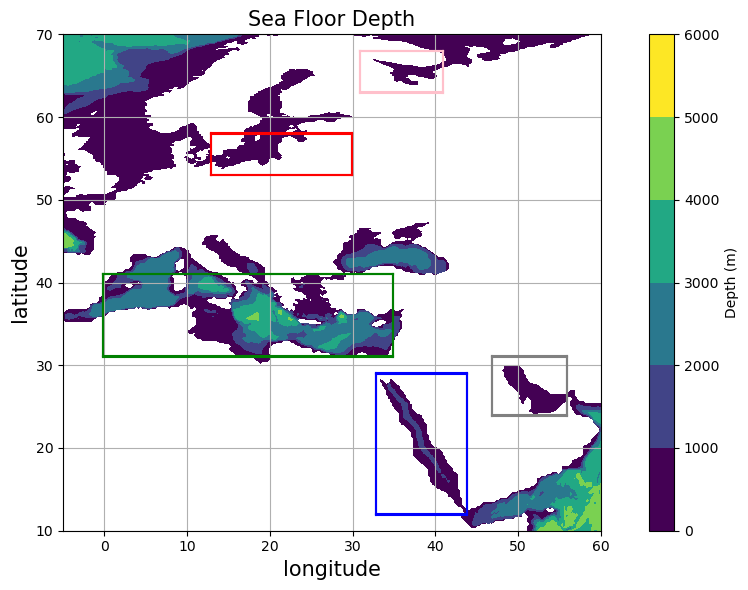

In [19]:
# OM3
xh = static.xh
yh = static.yh
xt_ocean = static_om2.xt_ocean
yt_ocean = static_om2.yt_ocean

# Baltic Sea
target_lon = [13, 30]
target_lat = [53, 58]
lon01, lat01 = construct_lon_lat(xt_ocean, yt_ocean, target_lon, target_lat)
lon1, lat1 = construct_lon_lat(xh, yh, target_lon, target_lat)

# Med Sea
target_lon = [0, 35]
target_lat = [31, 41]
lon02, lat02 = construct_lon_lat(xt_ocean, yt_ocean, target_lon, target_lat)
lon2, lat2 = construct_lon_lat(xh, yh, target_lon, target_lat)

# Red Sea
target_lon = [33, 44]
target_lat = [12, 29]
lon03, lat03 = construct_lon_lat(xt_ocean, yt_ocean, target_lon, target_lat)
lon3, lat3 = construct_lon_lat(xh, yh, target_lon, target_lat)

# Persian Gulf
target_lon = [47, 56]
target_lat = [24, 31]
lon04, lat04 = construct_lon_lat(xt_ocean, yt_ocean, target_lon, target_lat)
lon4, lat4 = construct_lon_lat(xh, yh, target_lon, target_lat)

# White Sea
target_lon = [31, 41]
target_lat = [63, 68]
lon05, lat05 = construct_lon_lat(xt_ocean, yt_ocean, target_lon, target_lat)
lon5, lat5 = construct_lon_lat(xh, yh, target_lon, target_lat)


figsize = (10, 6)
fig, ax = plt.subplots(figsize=figsize)

deptho.plot.contourf(
    ax=ax,
    x='longitude',
    y='latitude',
    cmap='viridis',
    cbar_kwargs={'label': 'Depth (m)'}
)
plot_rect(ax, lon1, lat1)
plot_rect(ax, lon2, lat2, color='g')
plot_rect(ax, lon3, lat3, color='b')
plot_rect(ax, lon4, lat4, color='gray')
plot_rect(ax, lon5, lat5, color='pink')

plot_rect(ax, lon01, lat01)
plot_rect(ax, lon02, lat02, color='g')
plot_rect(ax, lon03, lat03, color='b')
plot_rect(ax, lon04, lat04, color='gray')
plot_rect(ax, lon05, lat05, color='pink')

ax.grid(True)
title = deptho.attrs.get("long_name", "")
ax.set_title(title, fontsize=15)
ax.set_xlabel(ax.get_xlabel(), fontsize=15)
ax.set_ylabel(ax.get_ylabel(), fontsize=15)
xlims = [-5, 60]
ylims = [10, 70]
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect('equal')
plt.tight_layout()

In [20]:
def subplots_fig_ax(num_plots, ncols, figsize):
    if num_plots>1:
        nrows = (num_plots + ncols - 1) // ncols
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        axes = axes.flatten() if (nrows * ncols > 1) else [axes]
    else:
        fig, axes = plt.subplots(figsize=figsize)
    return fig, axes

0
0
1
2
3
4
1
0
1
2
3
4
2
0
1
2
3
4
3
0
1
2
3
4
4
0
1
2
3
4


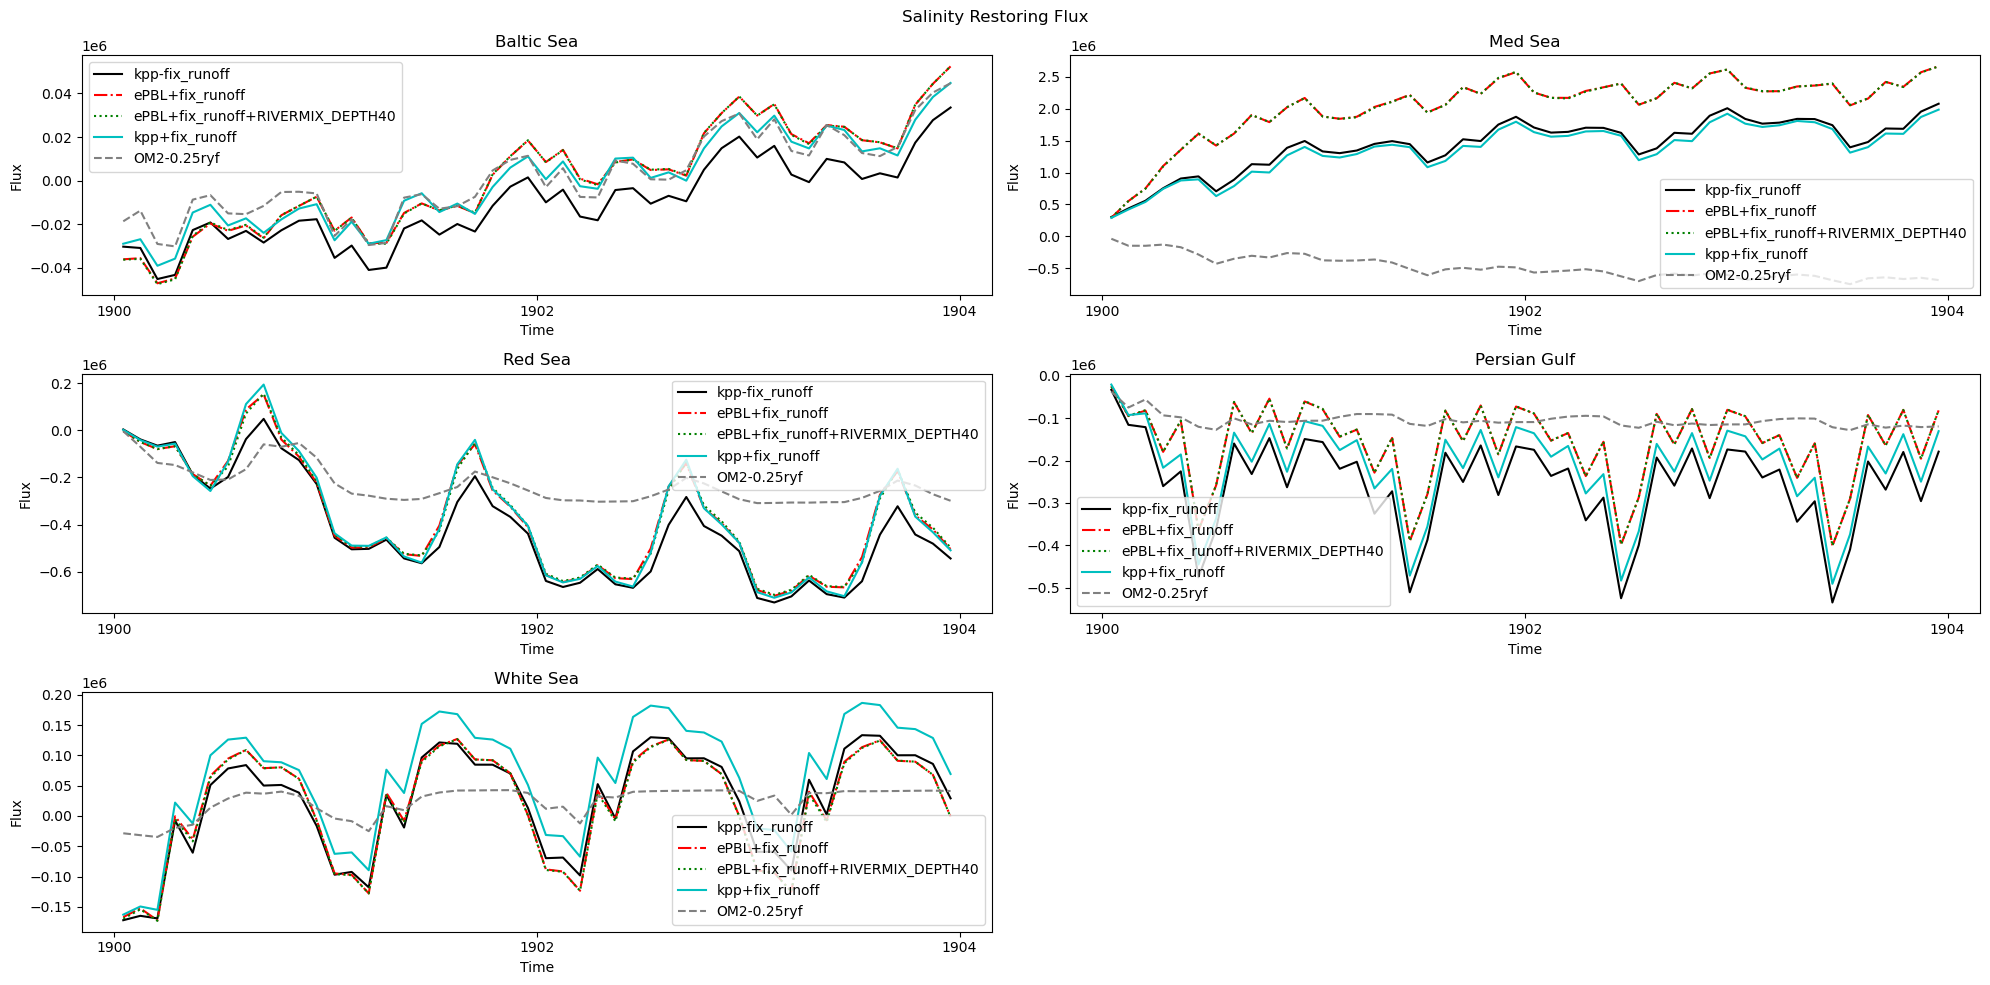

In [21]:
lon_lat_pairs_all = {
    "om3": [
        ([lon1[0], lon1[1]], [lat1[0], lat1[1]]),
        ([lon2[0], lon2[1]], [lat2[0], lat2[1]]),
        ([lon3[0], lon3[1]], [lat3[0], lat3[1]]),
        ([lon4[0], lon4[1]], [lat4[0], lat4[1]]),
        ([lon5[0], lon5[1]], [lat5[0], lat5[1]]),
    ],
    "om2": [
        ([lon01[0], lon01[1]], [lat01[0], lat01[1]]),
        ([lon02[0], lon02[1]], [lat02[0], lat02[1]]),
        ([lon03[0], lon03[1]], [lat03[0], lat03[1]]),
        ([lon04[0], lon04[1]], [lat04[0], lat04[1]]),
        ([lon05[0], lon05[1]], [lat05[0], lat05[1]]),
    ]
}

MOM_names = [
    "kpp-fix_runoff",
    "ePBL+fix_runoff",
    "ePBL+fix_runoff+RIVERMIX_DEPTH40",
    "kpp+fix_runoff",
    "OM2-0.25ryf",
] # user-defined
indx_om2 = 4

variable = "salt_flux_added"

colors = ["k", "r", "g", "c", "gray"]
styles = ["-", "-.", ":", '-', "--"]

figsize = (20, 10)
num_plots = len(lon_lat_pairs_all["om3"])
ncols = 2
fig, axes = subplots_fig_ax(num_plots, ncols, figsize)

axes = axes.flatten()

for pair_idx, (lon, lat) in enumerate(lon_lat_pairs_all["om3"]):
    print(pair_idx)
    ax = axes[pair_idx]
    for indx, i in enumerate(salt_flux_added_comparisons):
        if indx in (0,1,2,3,4): #is not None:# in (2,3,4): 
            print(indx)
            lon_lat_tmp = (
                lon_lat_pairs_all["om2"][pair_idx]
                if indx == indx_om2 else (lon, lat)
            )
            lon_tmp, lat_tmp = lon_lat_tmp

            tmp = (
                i[variable] * (area_t if indx == indx_om2 else areacello)
            ).sel(
                **{
                    ("xt_ocean" if indx == indx_om2 else "xh"): slice(lon_tmp[0], lon_tmp[1]),
                    ("yt_ocean" if indx == indx_om2 else "yh"): slice(lat_tmp[0], lat_tmp[1])
                }
            ).sum(
                ("xt_ocean" if indx == indx_om2 else "xh")
            ).sum(
                ("yt_ocean" if indx == indx_om2 else "yh")
            )
            
            tmp.plot(ax=ax, color=colors[indx], linestyle=styles[indx], label=f"{MOM_names[indx]}")

    ax.set_title(f"{seas[pair_idx]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Flux")
    ax.legend(loc="best")

    formatter = ScalarFormatter()
    formatter.set_scientific(True)
    formatter.set_powerlimits((6, 6))
    ax.yaxis.set_major_formatter(formatter)

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Salinity Restoring Flux", fontsize=12)

plt.tight_layout()

0
0
1
2
3
4
1
0
1
2
3
4
2
0
1
2
3
4
3
0
1
2
3
4
4
0
1
2
3
4


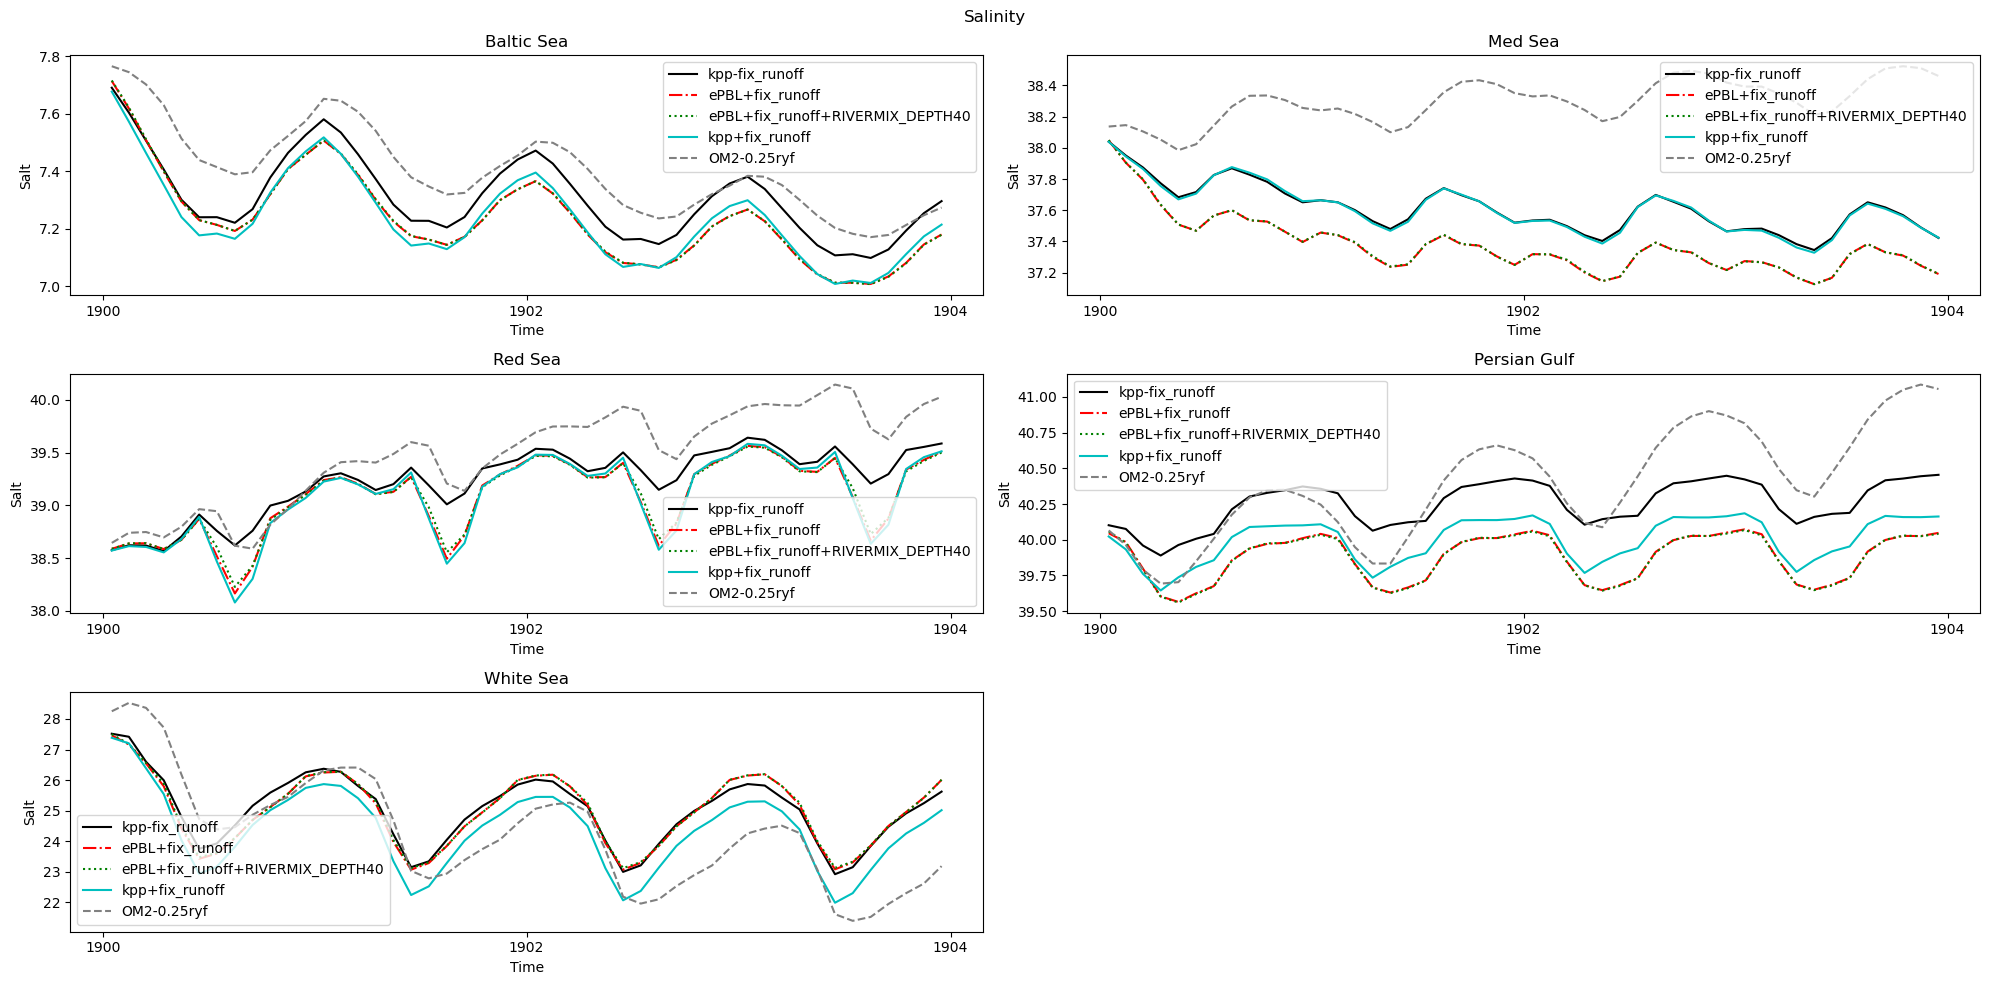

In [25]:
variable = "sos"

figsize = (20, 10)
num_plots = len(lon_lat_pairs_all["om3"])
ncols = 2
fig, axes = subplots_fig_ax(num_plots, ncols, figsize)

axes = axes.flatten()

for pair_idx, (lon, lat) in enumerate(lon_lat_pairs_all["om3"]):
    print(pair_idx)
    ax = axes[pair_idx]
    for indx, i in enumerate(sos_comparisons):
        if indx in (0,1,2,3,4): #is not None:# in (2,3,4): 
            print(indx)
            lon_lat_tmp = (
                lon_lat_pairs_all["om2"][pair_idx]
                if indx == indx_om2 else (lon, lat)
            )
            lon_tmp, lat_tmp = lon_lat_tmp

            tmp = (
                i[variable]
            ).sel(
                **{
                    ("xt_ocean" if indx == indx_om2 else "xh"): slice(lon_tmp[0], lon_tmp[1]),
                    ("yt_ocean" if indx == indx_om2 else "yh"): slice(lat_tmp[0], lat_tmp[1])
                }
            ).mean(
                ("xt_ocean" if indx == indx_om2 else "xh")
            ).mean(
                ("yt_ocean" if indx == indx_om2 else "yh")
            )
            
            tmp.plot(ax=ax, color=colors[indx], linestyle=styles[indx], label=f"{MOM_names[indx]}")

    ax.set_title(f"{seas[pair_idx]}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Salt")
    ax.legend(loc="best")

for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Salinity", fontsize=12)

plt.tight_layout()

In [40]:
# load surface restoring

path_salt_sfc_restore = "/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/New_grid_input_files_025deg_75zlevels/salt_sfc_restore.nc"
salt_sfc_restore = xr.open_mfdataset(path_salt_sfc_restore, decode_times=False)
print(salt_sfc_restore)
salt_sfc_restore = salt_sfc_restore.assign_coords({lon_coord: (["yh", "xh"], static["geolon"].values),
                                                   lat_coord: (["yh", "xh"], static["geolat"].values)})

<xarray.Dataset> Size: 79MB
Dimensions:  (time: 12, lat: 1142, lon: 1440)
Coordinates:
  * time     (time) float32 48B 0.5 1.5 2.5 3.5 4.5 ... 7.5 8.5 9.5 10.5 11.5
  * lat      (lat) float32 5kB -80.94 -80.87 -80.81 -80.74 ... 89.74 89.84 89.94
  * lon      (lon) float32 6kB -279.9 -279.6 -279.4 -279.1 ... 79.38 79.62 79.88
Data variables:
    salt     (time, lat, lon) float32 79MB dask.array<chunksize=(1, 1142, 1440), meta=np.ndarray>
Attributes:
    history:  Created by ek4684 (ezhilsabareesh8) on 2024-11-06, using https:...


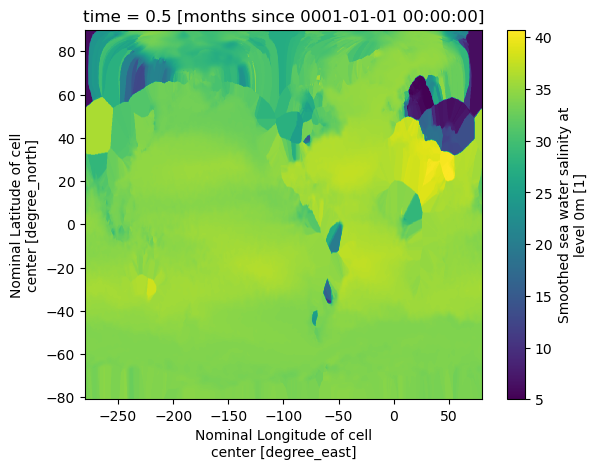

In [39]:
salt_sfc_restore['salt'].isel(time=0).plot()

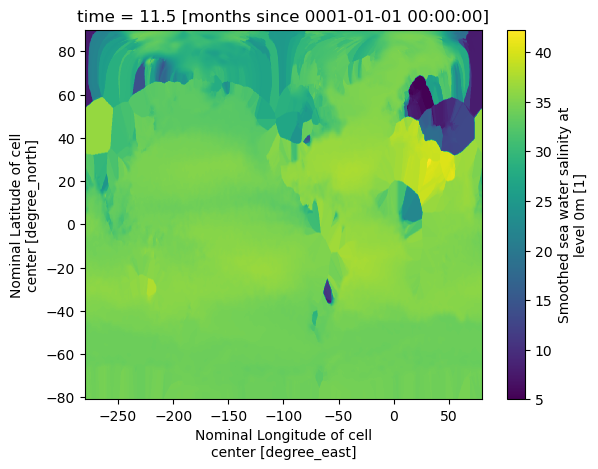

In [38]:
salt_sfc_restore['salt'].isel(time=11).plot()